In [1]:
import pandas as pd
import itertools as it
import numpy as np
import networkx as nx
from networkx.algorithms import community as nxcom
import matplotlib.pyplot as plt
import statistics as stat
import powerlaw as pw

In [2]:
path = 'C:/Users/Lenovo/Documents/GitHub/NetSci/dataset/imdb_pixar.xlsx'
excel_pixar = pd.ExcelFile(path)
sheets_pixar = excel_pixar.sheet_names[2:]
raw_pixar = dict((sheets_pixar[i], excel_pixar.parse(sheets_pixar[i])) for i in range(len(sheets_pixar)))

In [3]:
year_pixar = {'ToyStory': 1995, 'BugsLife': 1998, 'ToyStory2': 1999, 'MonsterInc': 2001, 'FindNemo': 2003, 'Incred': 2004,
              'Cars': 2006, 'Ratat': 2007, 'WallE': 2008, 'Up': 2009, 'ToyStory3': 2010, 'Cars2': 2011, 'Brave': 2012, 
              'MonsU': 2013, 'InsideOut': 2015, 'GoodDino': 2015, 'FindDory': 2016, 'Cars3': 2017, 'CoCo': 2017, 
              'Incred2': 2018, 'ToyStory4': 2019}

In [4]:
for film in sheets_pixar:
    print("\nfilm:", film)
    raw_pixar[film]['film'] = film
    raw_pixar[film]['year'] = year_pixar[film]
    print(raw_pixar[film][0:4])


film: ToyStory
             crew      dept        function      film  year
0   John Lasseter  director        director  ToyStory  1995
1   John Lasseter   writers  original story  ToyStory  1995
2     Pete Docter   writers  original story  ToyStory  1995
3  Andrew Stanton   writers  original story  ToyStory  1995

film: BugsLife
             crew       dept        function      film  year
0   John Lasseter  direction        director  BugsLife  1998
1  Andrew Stanton  direction     co-director  BugsLife  1998
2   John Lasseter    writers  original story  BugsLife  1998
3  Andrew Stanton    writers  original story  BugsLife  1998

film: ToyStory2
            crew       dept        function       film  year
0  John Lasseter  direction        director  ToyStory2  1999
1    Ash Brannon  direction     co-director  ToyStory2  1999
2    Lee Unkrich  direction     co-director  ToyStory2  1999
3  John Lasseter    writers  original story  ToyStory2  1999

film: MonsterInc
              crew     

In [5]:
#Concatenate the films into one flat file
data_pixar = pd.concat(raw_pixar).replace({'dept': {'director': 'direction', 'co-director': 'direction'}})
print(data_pixar)

                            crew       dept                      function  \
ToyStory  0        John Lasseter  direction                      director   
          1        John Lasseter    writers                original story   
          2          Pete Docter    writers                original story   
          3       Andrew Stanton    writers                original story   
          4            Joe Ranft    writers                original story   
...                          ...        ...                           ...   
ToyStory4 102       David Torres  animation                      animator   
          103  Luis Carlos Uribe  animation                      animator   
          104       David Verona  animation                  Rendering TD   
          105      Amanda Wagner  animation                      animator   
          106       Sarita White  animation  animation department manager   

                    film  year  
ToyStory  0     ToyStory  1995  
         

In [6]:
data_pixar.columns

Index(['crew', 'dept', 'function', 'film', 'year'], dtype='object')

#### Ensuring the values of each variable is unique for each film data

In [7]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [8]:
def verify_unique(df, var):
    df['ones'] = 1
    unique = df.groupby(var)['ones'].sum()
    print("Verify: {}. Total entries: {}. Unique entries: {}".format(var, len(df.index), len(unique)))
    print_full(df.groupby(var)['ones'].sum())

In [9]:
verify_unique(data_pixar, 'crew')

Verify: crew. Total entries: 5746. Unique entries: 1619
crew
A.J. Riebli III                  1
Aaron Conover                    4
Aaron Haynes                     2
Aaron J. Hartline                6
Aaron Koressel                   7
Aaron Luk                        1
Abby Davies                      1
Adam Burke                       9
Adam Campbell                    1
Adam Habib                       6
Adam Rodriguez                   6
Adam Schnitzer                   5
Adam Wood                        6
Adam Woodbury                    3
Adel Abada                       1
Adrian Bell                      4
Adrian Molina                    8
Adrian Ochoa                     1
Adrienne Othon                   2
Afonso Salcedo                   6
Aimei Kutt                       6
Airton Dittz Jr.                10
Alan Barillaro                   8
Alan Browning                    1
Alan Sperling                    4
Albert Lozano                    9
Alden Chew                   

In [10]:
len(data_pixar.index)

5746

In [11]:
see = data_pixar
see['ones'] = 1
unique = see.groupby('crew')['ones'].sum()
print(len(list(see.groupby('crew')['ones'])))
print(unique)



1619
crew
A.J. Riebli III      1
Aaron Conover        4
Aaron Haynes         2
Aaron J. Hartline    6
Aaron Koressel       7
                    ..
Yvonne Herbst        6
Zach Repasky         4
Zaruhi Galstyan      1
Ziah Sarah Fogel     6
Zoe Boxer            2
Name: ones, Length: 1619, dtype: int64


#### Create fully connected graph among the nodes for each film

##### Model 1
In this model we shall consider only the directors, story writers, screenplay and producers. And we presume that they are knitted together.

In [12]:
#Check the unique values of dept
print(data_pixar['dept'].unique())

#Clean up the values and store the extracted in data_pixar1
data_pixar1 = data_pixar.replace({'dept': {'director': 'direction', 'co-director': 'direction', 
                                           'art dept': 'art', 'animation dept': 'animation'}})
print("unique values dept", data_pixar1['dept'].unique())

#Extract values
data_pixar1.loc['dept'] = 'direction'


#Drop duplicates. Each node should be unique
#data_pixar1 = data_pixar1.drop_duplicates(['a','b'])

['direction' 'writers' 'screenplay' 'producer' 'art direction' 'art dept'
 'visual effects' 'animation' 'prod mgmt' 'animation dept' 'art']
unique values dept ['direction' 'writers' 'screenplay' 'producer' 'art direction' 'art'
 'visual effects' 'animation' 'prod mgmt']


#### Create a data set for network graph
1. Limit data_pixar by crew
2. drop duplictaes in each film
3. combination of edges
4. append to model1

In [13]:
#Store the nodes for Model1
scope = ['direction', 'producer', 'writers', 'screenplay']
data1 = data_pixar.loc[data_pixar['dept'].isin(scope)]
nodes_pixar = pd.DataFrame()
for film in sheets_pixar:
    crew = data1.loc[data1['film']==film].drop_duplicates('crew')
    nodes = crew['crew']
    nodes_pixar = pd.concat([nodes_pixar, nodes])
nodes_pixar = nodes_pixar.drop_duplicates()
nodes_pixar['studio'] = 'pixar'
print(nodes_pixar)

#Save the data set
nodes_pixar.to_csv('C:/Users/Lenovo/Documents/GitHub/NetSci/dataset/nodes_pixar.csv')

                               0 studio
(ToyStory, 0)      John Lasseter  pixar
(ToyStory, 2)        Pete Docter  pixar
(ToyStory, 3)     Andrew Stanton  pixar
(ToyStory, 4)          Joe Ranft  pixar
(ToyStory, 5)        Joss Whedon  pixar
...                          ...    ...
(ToyStory4, 4)  Valerie LaPointe  pixar
(ToyStory4, 5)     Rashida Jones  pixar
(ToyStory4, 6)    Will McCormack  pixar
(ToyStory4, 7)      Martin Hynes  pixar
(ToyStory4, 8)   Stephany Folsom  pixar

[96 rows x 2 columns]


In [13]:
#Model1
#scope = ['direction', 'writers', 'screenplay', 'producer', 'art direction']
scope = ['direction', 'writers', 'screenplay', 'producer']
#scope = ['direction', 'writers', 'screenplay', 'producer', 'art direction', 'animation', 'animation dept']
data1 = data_pixar.loc[data_pixar['dept'].isin(scope)]
model1 = pd.DataFrame()
for film in sheets_pixar:
    crew = data1.loc[data1['film']==film].drop_duplicates('crew')
    nodes = crew['crew']
    edges = pd.DataFrame(it.combinations(nodes, 2)).rename(columns = {0: 'source', 1: 'target'})
    edges['film'] = film
    edges['year'] = year_pixar[film]
    edges['studio'] = 'Pixar'
    print("\nFilm:", film)
    print("Data:", edges[0:3])
    model1 = pd.concat([model1, edges])

print("\nModel 1:", model1)
        


Film: ToyStory
Data:           source          target      film  year studio
0  John Lasseter     Pete Docter  ToyStory  1995  Pixar
1  John Lasseter  Andrew Stanton  ToyStory  1995  Pixar
2  John Lasseter       Joe Ranft  ToyStory  1995  Pixar

Film: BugsLife
Data:           source          target      film  year studio
0  John Lasseter  Andrew Stanton  BugsLife  1998  Pixar
1  John Lasseter       Joe Ranft  BugsLife  1998  Pixar
2  John Lasseter     Don McEnery  BugsLife  1998  Pixar

Film: ToyStory2
Data:           source       target       film  year studio
0  John Lasseter  Ash Brannon  ToyStory2  1999  Pixar
1  John Lasseter  Lee Unkrich  ToyStory2  1999  Pixar
2  John Lasseter  Pete Docter  ToyStory2  1999  Pixar

Film: MonsterInc
Data:         source           target        film  year studio
0  Pete Docter  David Silverman  MonsterInc  2001  Pixar
1  Pete Docter      Lee Unkrich  MonsterInc  2001  Pixar
2  Pete Docter      Jill Culton  MonsterInc  2001  Pixar

Film: FindNemo
D

In [14]:
#Save the data set
model1.to_csv('C:/Users/Lenovo/Documents/GitHub/NetSci/dataset/model1_pixar.csv')

print("Model1 length:", len(model1))

Model1 length: 862


#### Drawing the Network

In [15]:
G = nx.from_pandas_edgelist(model1, source = 'source', target = 'target', create_using=nx.Graph())

In [16]:
print("Nodes: {}. Edges: {}".format(len(G.nodes), len(G.edges)))

Nodes: 96. Edges: 711


C:\Users\Lenovo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


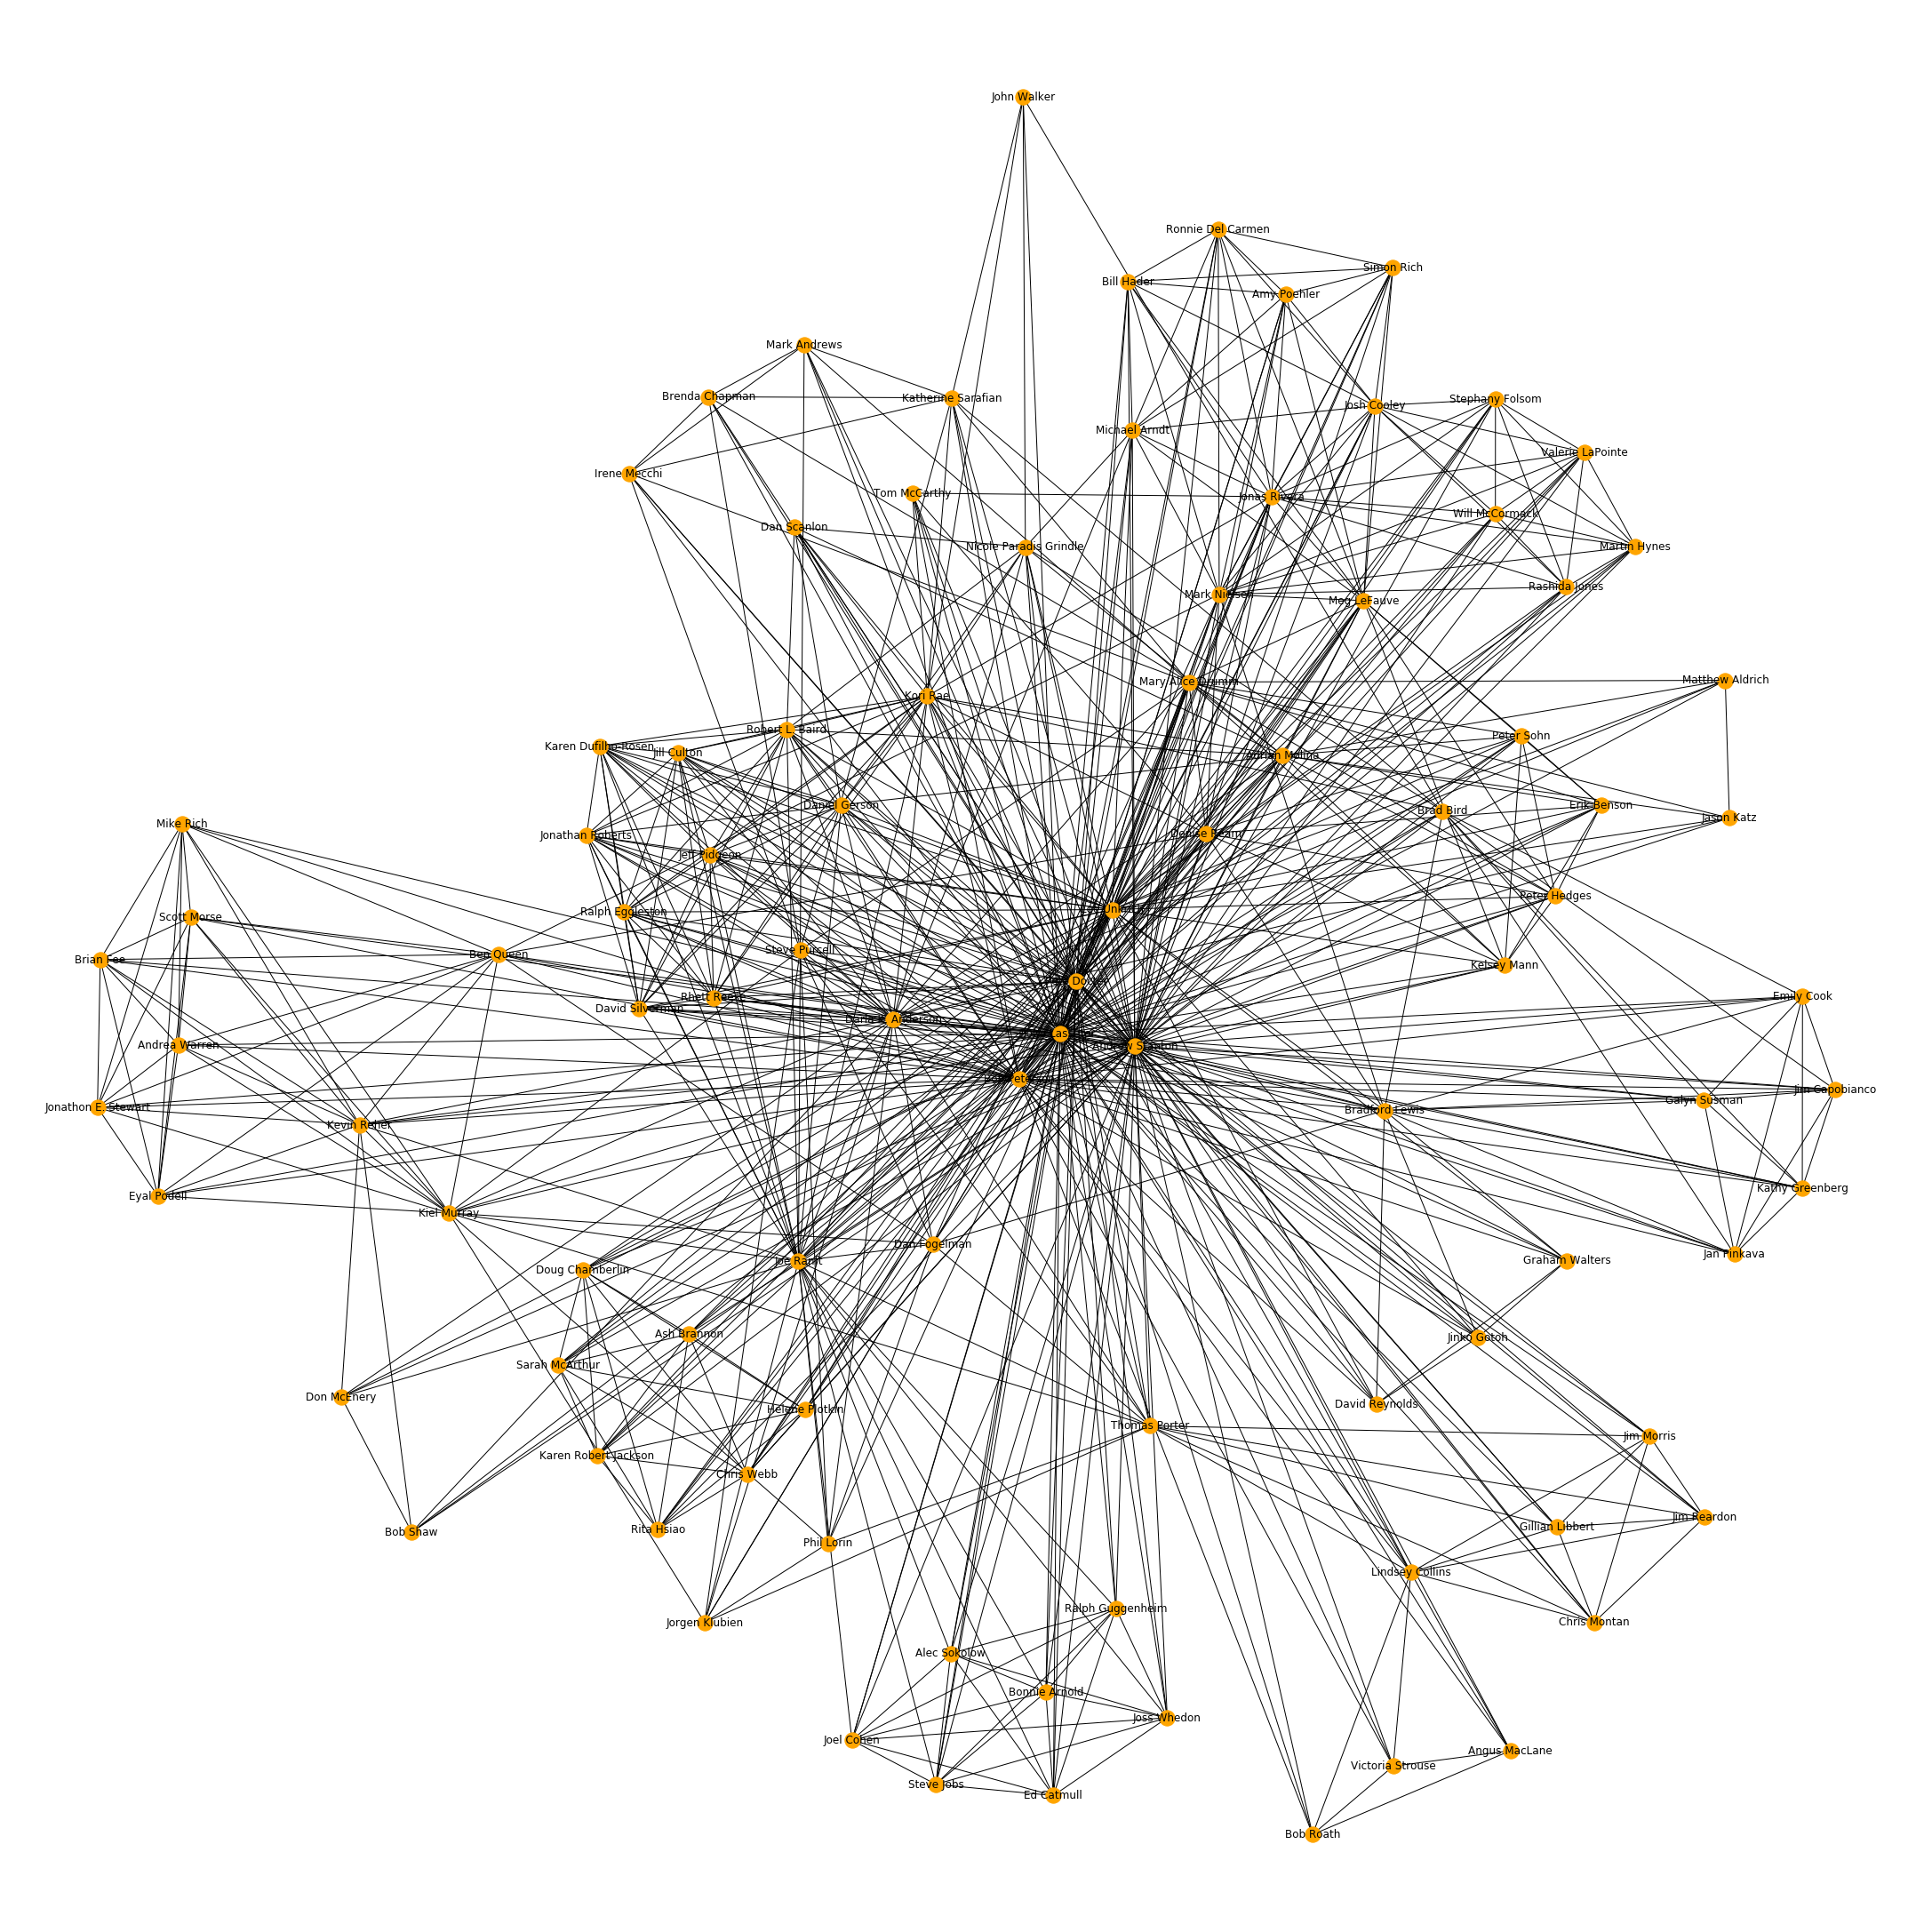

In [17]:
#Graph 1
plt.figure(figsize = (30, 30))
nx.draw_spring(G, with_labels=True, node_color='orange')

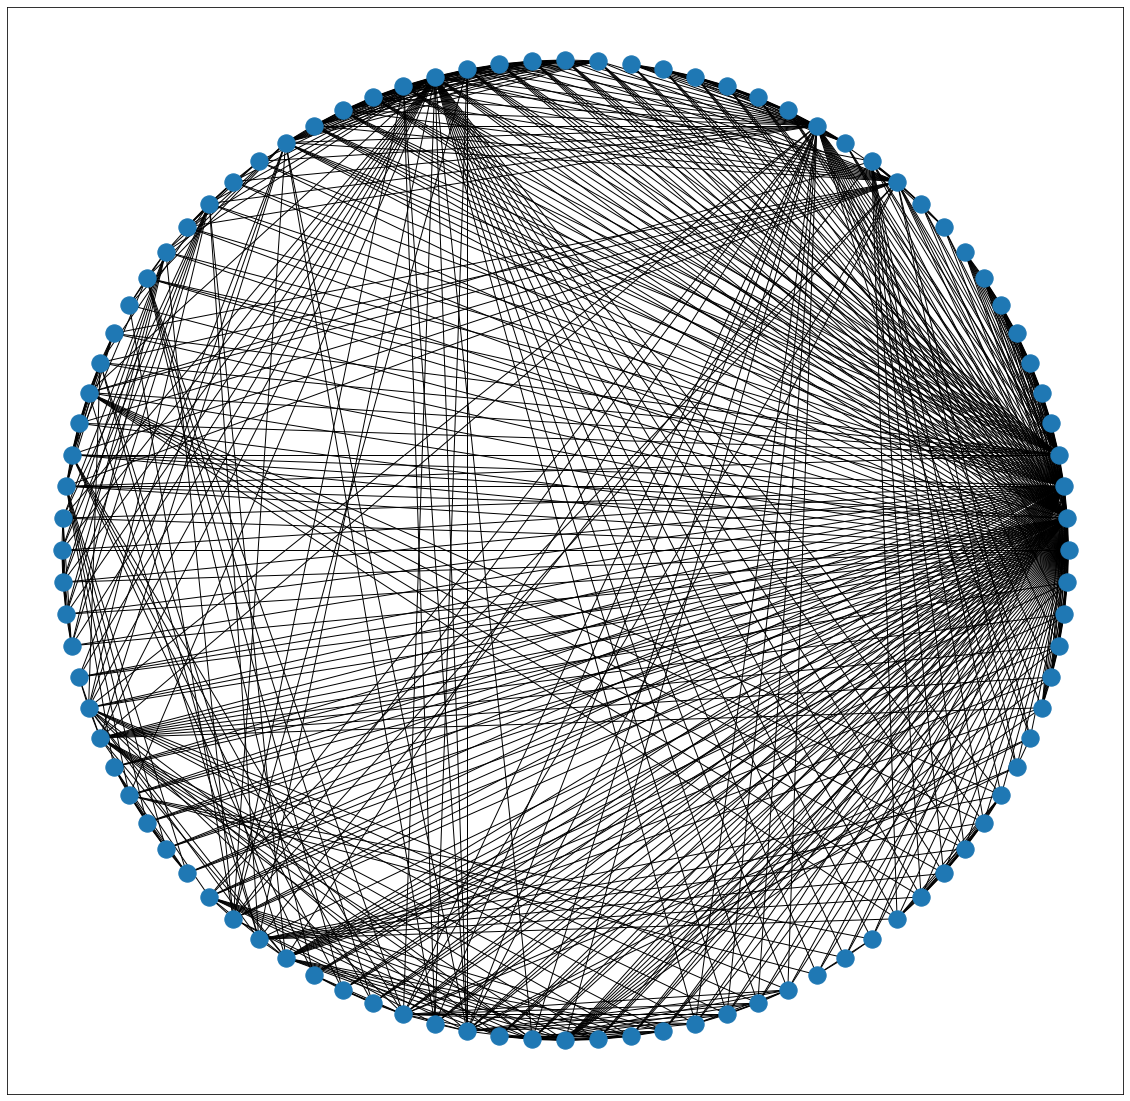

In [18]:
#Graph 2
plt.figure(figsize = (20, 20))
nx.draw_networkx(G, pos = nx.circular_layout(G), with_labels=False)

The links almost resembles a random network. We expect that in this network where almost all the nodes have collaborated with each other, the network is almost random.

#### Degree distribution: Is this network scale-free?

In [19]:
#Take the degrees
degrees = [G.degree(node) for node in G]
degrees.sort(reverse=True)
kmin = min(degrees)
kmax = max(degrees)
print("Degree sequence", degrees)
print("Degree min", kmin)
print("Degree max", kmax)
print("Degree mean", stat.mean(degrees))
print("Degree sd", stat.stdev(degrees))

Degree sequence [95, 81, 61, 49, 48, 32, 31, 25, 21, 21, 20, 20, 20, 19, 19, 19, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5]
Degree min 5
Degree max 95
Degree mean 14.8125
Degree sd 13.880931638686747


In [20]:
#We shall use the powerlaw package developed by Alstott, et al.
fit = pw.Fit(degrees)

Calculating best minimal value for power law fit
C:\Users\Lenovo\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Text(0.5, 1.0, 'Degree distribution (dotted) and Theoretical PDF (line)')

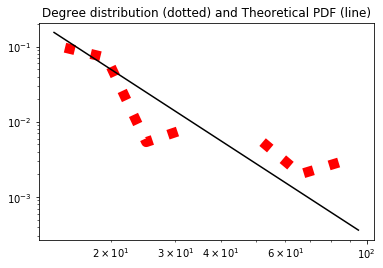

In [21]:
#Plot of the strength distribution in Log-log scale and the theoretical pdf
fig1 = fit.plot_pdf(color='r', linewidth = 10, linestyle= ":")
fit.power_law.plot_pdf(color='black', linestyle="-", ax=fig1)
plt.title('Degree distribution (dotted) and Theoretical PDF (line)')

In [22]:
#MLE Estimate of alpha, [Clauset, et al. 2009]
print("MLE for alpha:", fit.power_law.alpha)

MLE for alpha: 3.160334761162248


#### Size of the network

In [23]:
#Diameter: longest path
print("Diameter:", nx.diameter(G))

#Average path
print("Average shortest path", nx.average_shortest_path_length(G))

Diameter: 2
Average shortest path 1.8440789473684212


In [24]:
def path_length_histogram(G, title=None):
    # Find path lengths
    length_source_target = dict(nx.shortest_path_length(G))
    # Convert dict of dicts to flat list
    all_shortest = sum([list(length_target.values())
        for length_target in length_source_target.values()], [])
    # Calculate integer bins
    high = max(all_shortest)
    bins = [-0.5 + i for i in range(high + 2)]
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(all_shortest, bins=bins, rwidth=0.8)
    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.tight_layout()

([<matplotlib.axis.XTick at 0x22316b345c8>,
 <a list of 3 Text xticklabel objects>)

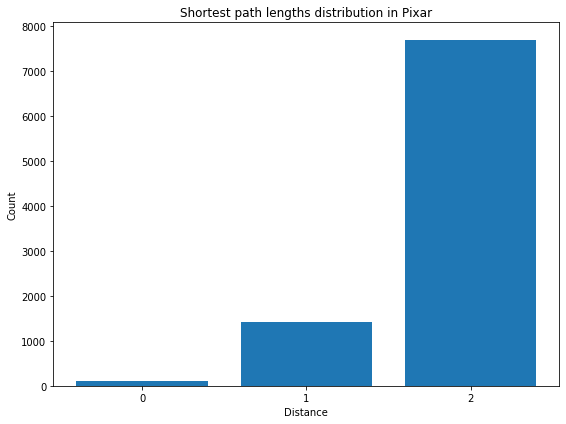

In [25]:
path_length_histogram(G, title="Shortest path lengths distribution in Pixar")
plt.xticks([0, 1, 2])

#### Measures of Centrality

In [26]:
#Global clustering
print("Transitivity:", nx.transitivity(G))
print("Average clustering:", nx.average_clustering(G))

Transitivity: 0.4049438676013282
Average clustering: 0.8642141409013954


#### The Central Airports: The hubs, the most in-between, and the closest

In [27]:
#Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G)
print("The top 10 hubs:")
sorted(eigenvector.items(), key=lambda x:x[1], reverse=True)[0:10]

The top 10 hubs:


[('John Lasseter', 0.3429620693288049),
 ('Andrew Stanton', 0.316340185707368),
 ('Pete Docter', 0.26630185932699674),
 ('Lee Unkrich', 0.23212936317034752),
 ('Bob Peterson', 0.2167236266889494),
 ('Darla K. Anderson', 0.16869298972345292),
 ('Joe Ranft', 0.16586649214950525),
 ('Kori Rae', 0.1566205850399646),
 ('Daniel Gerson', 0.13709135026359448),
 ('Robert L. Baird', 0.13709135026359448)]

In [28]:
#Local Clustering Coefficient of the top-10 Hubs
clustering = nx.clustering(G)
print("The local clustering coeff of the top 10 hubs:")
[(x, clustering[x]) for x in sorted(G, key=lambda x:eigenvector[x], reverse=True)[0:10]]

The local clustering coeff of the top 10 hubs:


[('John Lasseter', 0.1379619260918253),
 ('Andrew Stanton', 0.16358024691358025),
 ('Pete Docter', 0.226775956284153),
 ('Lee Unkrich', 0.2987588652482269),
 ('Bob Peterson', 0.26785714285714285),
 ('Darla K. Anderson', 0.43655913978494626),
 ('Joe Ranft', 0.41935483870967744),
 ('Kori Rae', 0.58),
 ('Daniel Gerson', 0.8421052631578947),
 ('Robert L. Baird', 0.8421052631578947)]

In [29]:
#Betweenness Centrality
betweenness = nx.betweenness_centrality(G, normalized=False)
print("The top 10 hubs and their betweenness")
sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[0:10]

The top 10 hubs and their betweenness


[('John Lasseter', 1646.9273809523816),
 ('Andrew Stanton', 888.3738095238092),
 ('Pete Docter', 392.4071428571429),
 ('Bob Peterson', 287.44801587301595),
 ('Lee Unkrich', 202.14523809523814),
 ('Joe Ranft', 80.78928571428567),
 ('Darla K. Anderson', 69.94642857142857),
 ('Kori Rae', 27.38492063492064),
 ('Mark Nielsen', 23.68214285714286),
 ('Mary Alice Drumm', 23.428968253968257)]

In [30]:
#Closeness Centrality
closeness = nx.closeness_centrality(G)
print("The top 10 hubs and their closeness")
#[(x, closeness[x]) for x in sorted(G1, key=lambda x:eigenvector[x], reverse=True)[0:10]]
sorted(closeness.items(), key=lambda x: x[1], reverse=True)[0:10]

The top 10 hubs and their closeness


[('John Lasseter', 1.0),
 ('Andrew Stanton', 0.8715596330275229),
 ('Pete Docter', 0.7364341085271318),
 ('Bob Peterson', 0.6737588652482269),
 ('Lee Unkrich', 0.6690140845070423),
 ('Joe Ranft', 0.6012658227848101),
 ('Darla K. Anderson', 0.5974842767295597),
 ('Kori Rae', 0.5757575757575758),
 ('Jonas Rivera', 0.5621301775147929),
 ('Mark Nielsen', 0.5621301775147929)]

#### Community structure

In [31]:
#Greedy algo
# Find the communities
print("Community Detection: Clauset-Newman-Moore Greedy Algorithm")
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

# Count the communities
print("Number of communities:", len(communities))
for i in range(len(communities)):
    print("")
    print("Community {}: {}".format(i+1, list(communities[i])))

Community Detection: Clauset-Newman-Moore Greedy Algorithm
Number of communities: 7

Community 1: ['Victoria Strouse', 'Mark Andrews', 'Andrew Stanton', 'Jim Morris', 'Angus MacLane', 'Brenda Chapman', 'Joel Cohen', 'Lindsey Collins', 'Irene Mecchi', 'Bonnie Arnold', 'Steve Jobs', 'Ralph Guggenheim', 'Jim Reardon', 'Bob Roath', 'Alec Sokolow', 'Chris Montan', 'Pete Docter', 'Joss Whedon', 'Ed Catmull', 'Gillian Libbert']

Community 2: ['Thomas Porter', 'Steve Purcell', 'Kevin Reher', 'Don McEnery', 'Phil Lorin', 'Bob Peterson', 'Eyal Podell', 'Brian Fee', 'Mike Rich', 'Kiel Murray', 'Andrea Warren', 'Ben Queen', 'Jonathon E. Stewart', 'Scott Morse', 'Darla K. Anderson', 'Jorgen Klubien', 'Dan Fogelman', 'Bob Shaw', 'Joe Ranft']

Community 3: ['Jan Pinkava', 'Galyn Susman', 'John Walker', 'Tom McCarthy', 'David Reynolds', 'John Lasseter', 'Kathy Greenberg', 'Dan Scanlon', 'Kori Rae', 'Bradford Lewis', 'Nicole Paradis Grindle', 'Brad Bird', 'Graham Walters', 'Jim Capobianco', 'Emily Cook

In [32]:
#Visualization
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
            
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
            
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [33]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]
internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]
internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

C:\Users\Lenovo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\Lenovo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


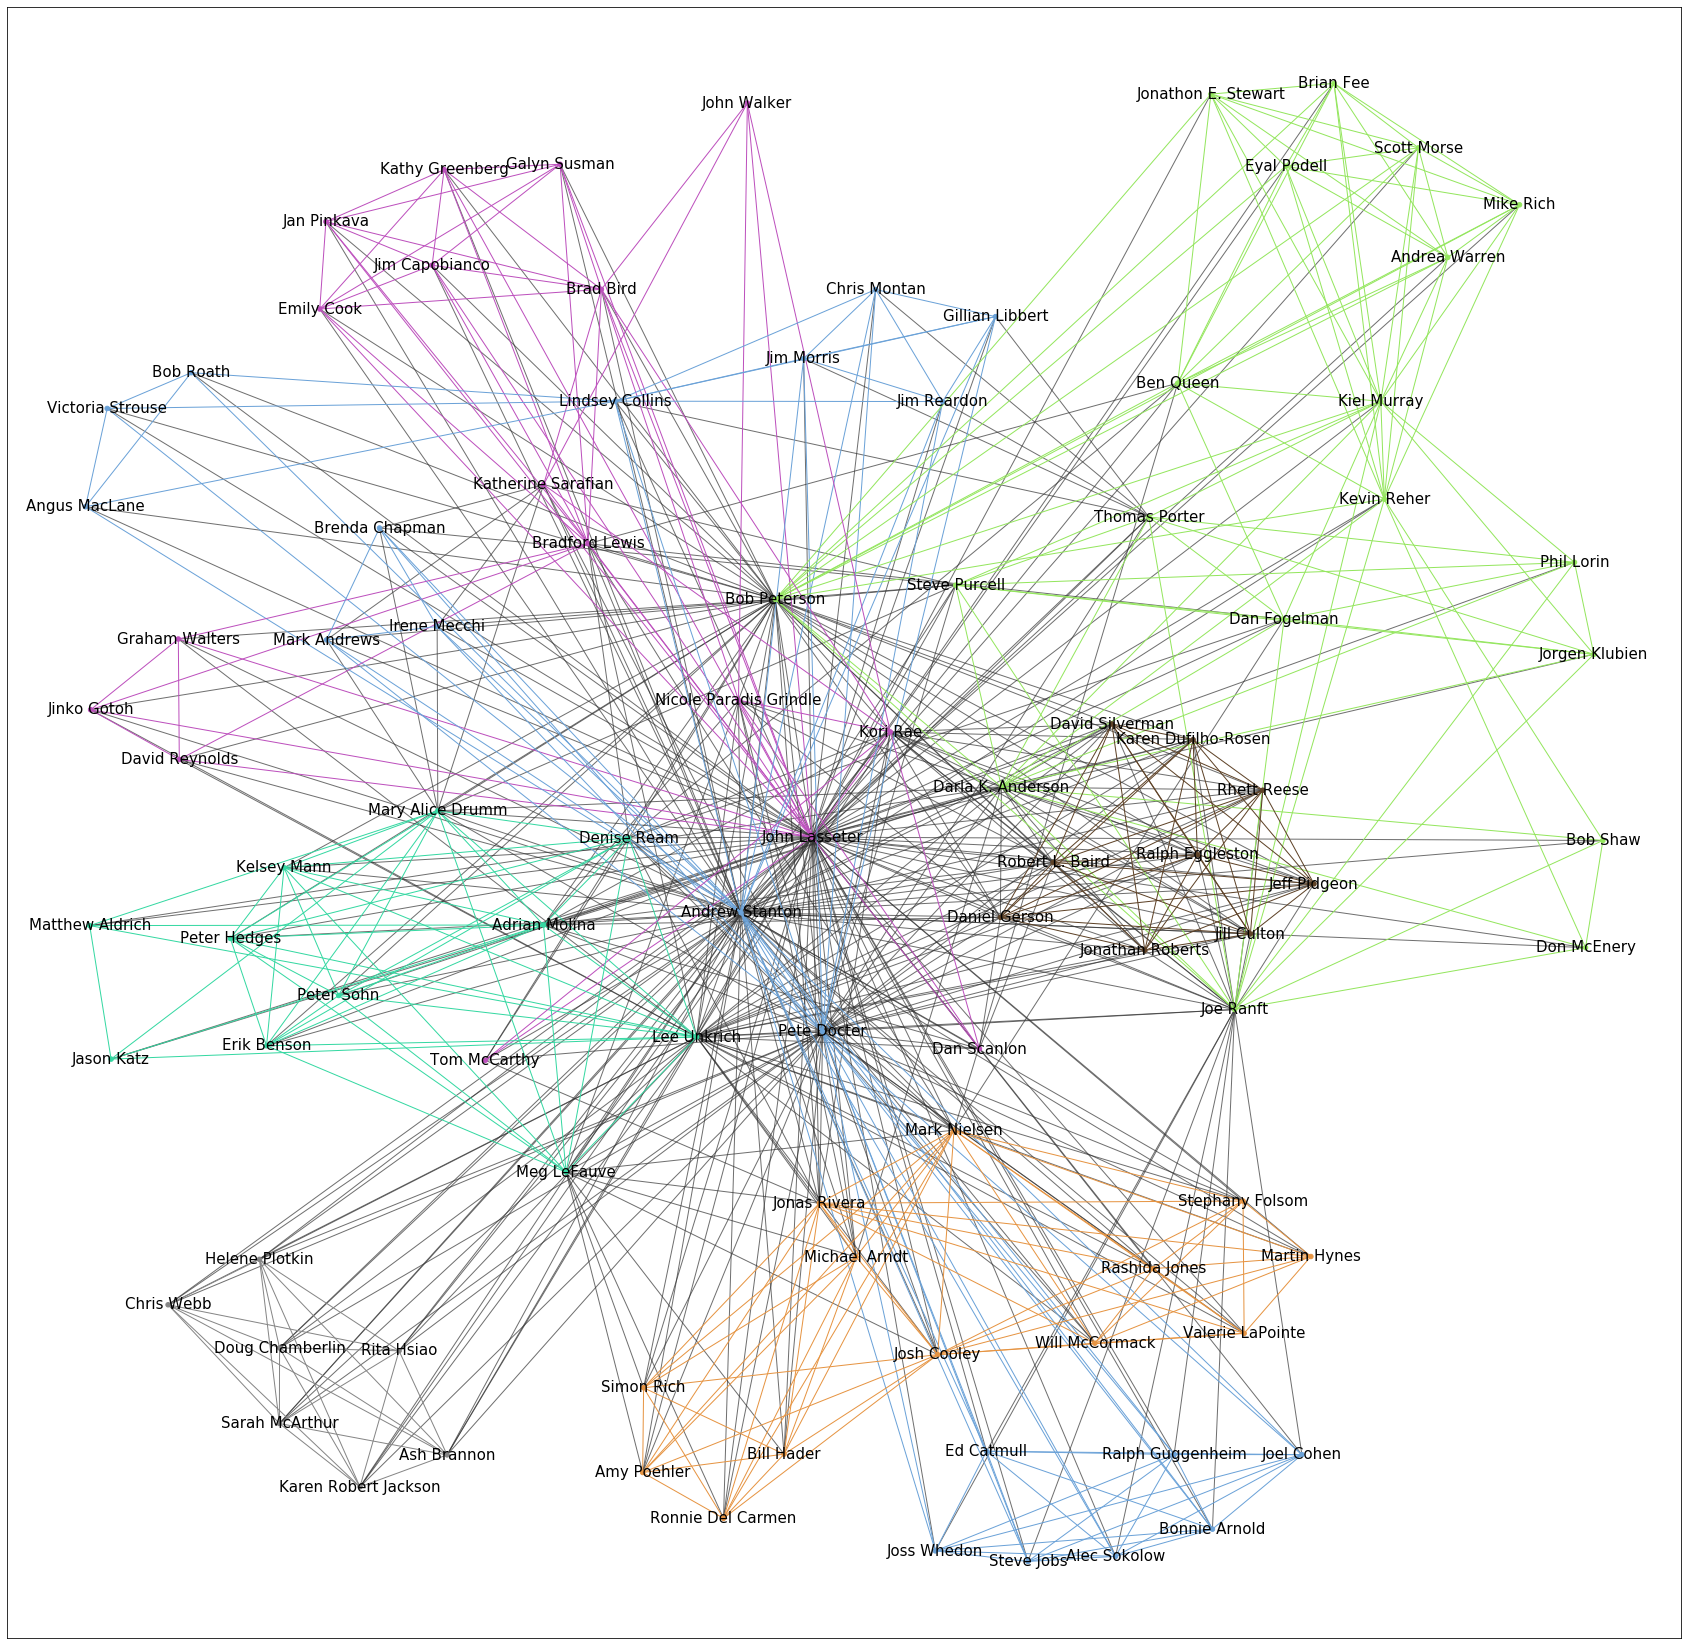

In [34]:
plt.figure(figsize=(30, 30))
pos = nx.spring_layout(G)
# Draw external edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333", with_labels=False, alpha = 0.7, font_size = 15)
# Draw nodes and internal edges
nx.draw_networkx(
    G, pos=pos, node_color=node_color,
    edgelist=internal, edge_color=internal_color, node_size=20, 
    with_labels=True, font_size = 15)
#plt.title("Communities of Directors, Writers, Screenplay and Producers in Pixar")